## `by Magomedov Rustam`

# Welcome to the final project!
In this notebook you will be asked to use singular value decomposition and SVM to classify images. We will be working with the MNIST numbers dataset, where training data consist of pictures of digits, and the target value is the digit itself.

First, we import the necessary libraries.

In [1]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

Now, we read both training and test dataset as arrays. 

In [2]:
data = np.load('mnist.npz')
X_test_total, X_train_total, y_train_total, y_test_total = data['x_test'], data['x_train'], data['y_train'], data['y_test']

Let's select two digits that we will be learning to separate, for example 3 and 8.

In [3]:
num1, num2 = 3, 8

Let us form the lists of indices i such that the target of i-th object of our training data is either num1 or num2. Do the same for the test dataset.

In [4]:
train_indx = [y == num1 or y == num2 for y in y_train_total] 
test_indx = [y == num1 or y == num2 for y in y_test_total] 

Form new arrays consisting of the data with the target values num1 and num2 only. 

In [5]:
X_train, y_train = X_train_total[train_indx], y_train_total[train_indx]
X_test, y_test = X_test_total[test_indx], y_test_total[test_indx]

## Looking at the data

Let us check the sizes of the datasets and the shape of one image.

In [6]:
print('Data shapes: ')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Data shapes: 
X_train:  (11982, 28, 28)
y_train:  (11982,)
X_test:  (1984, 28, 28)
y_test:  (1984,)


In [7]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

n_train, n_test

(11982, 1984)

In [8]:
print('Shape of one item: ')
print(X_train[0].shape)

Shape of one item: 
(28, 28)


Train data are images of digits.

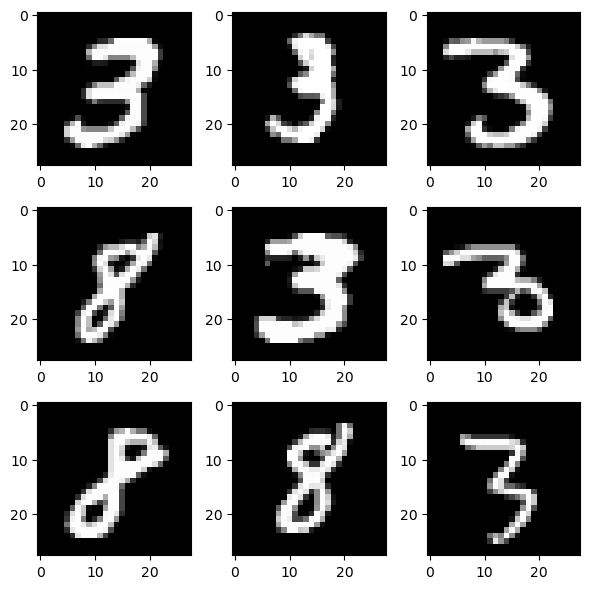

In [9]:
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    plt.imshow(X_train[i], cmap='gray')
plt.tight_layout()
plt.show()

Target values are numbers.

In [10]:
y_train[:9]

array([3, 3, 3, 8, 3, 3, 8, 8, 3], dtype=uint8)

## Task 1 (1 point)
Now our data is 3-dimensional of shape (number of images, n_pixels, n_pixels). To work with PCA and SVM we need to flatten the images by turning each of them into an array of shape (n_pixels x n_pixels, ).

In [11]:
def flatten_image(X):
    return X.reshape(-1)

In [12]:
X_train_flat = np.array([flatten_image(img) for img in X_train])
X_test_flat = np.array([flatten_image(img) for img in X_test])
X_train_flat.shape, X_test_flat.shape

((11982, 784), (1984, 784))

PCA works best when the data is scaled (think, why?), so let's scale our data. We will use [StandartScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for it. Note, that scaling replaces a collection of vectors x by the collection of the vectors $x' = (x-M)/D$, where $M$ is the mean vector of
the sample, $D$ is the vector of standard deviations of all components of the vectors, and the division is component-wise. So, the scaled collection has the same size as the original one, and each column has 0 mean and unit standard deviation.


In [13]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

## Question 1

Please write your answer on the impact of scaling below. Why does scaling help PCA? If your idea need some computer experiments for confirmation (say, training and accuracy calculations  with non-scaled data), please provide the code here as well.

***Your answer here.***

In the case of PCA, we need to standardize the data to avoid the drastic impact of the components with _high variance_. Since PCA is based on the maximization of the variance of each component, standardization becomes essential to equailize the importance of the components within the model, otherwise we diminish the importance of components with low variance and overestimate the importance of highly variable components. _StandardScaler()_ standardizes the features to comparable scales, removing potential impact of skewed, highly variable data. I'd also add that scaling per se is not the magic solution, because scaled data still can be influenced by outliers, so prior data cleaning is also necessary to obtain a more coherent results.

Below I show how non-standardized data may be decieving and resulting in arbitrary clusters when scales are not adjusted properly.

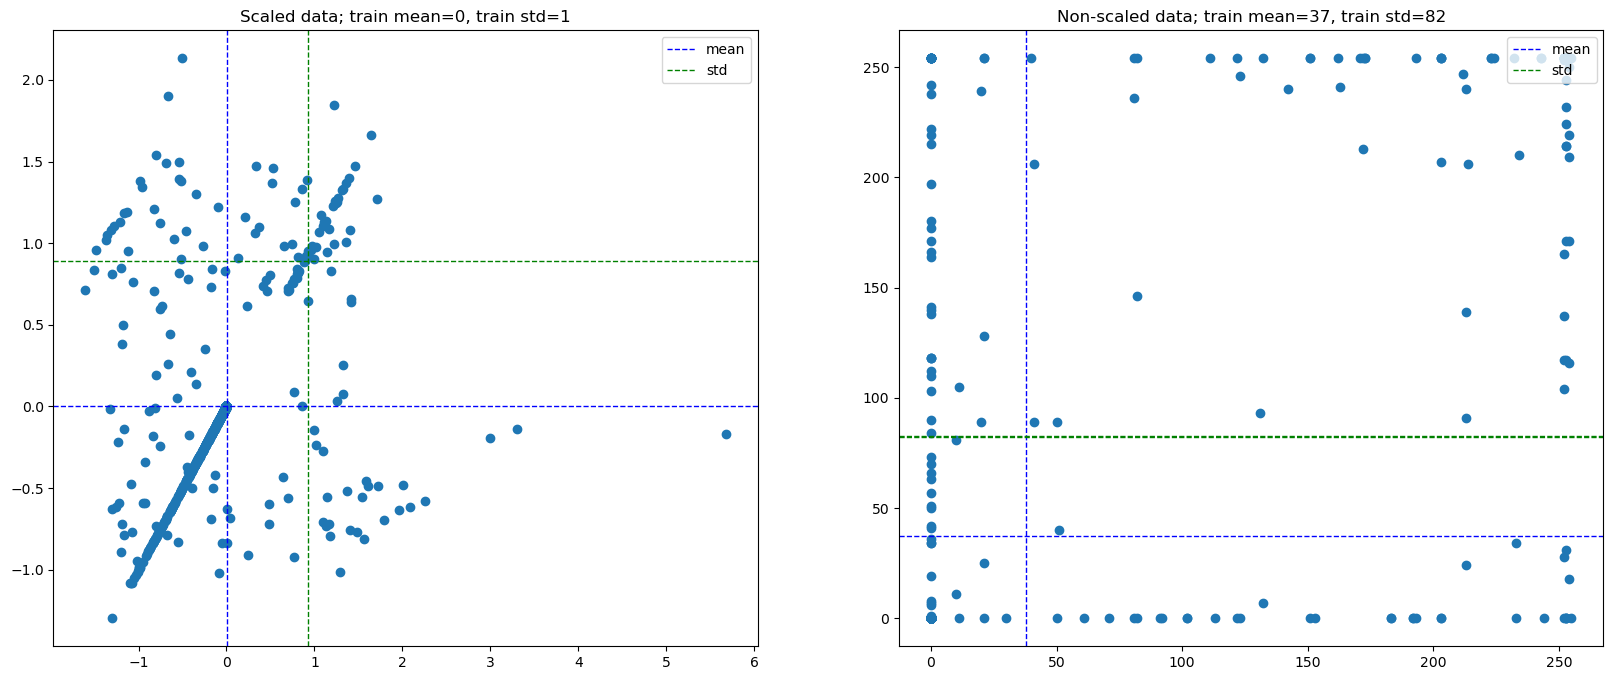

In [14]:
plt.figure(figsize=(20, 8))

# scaled data profile
plt.subplot(1, 2, 1)
plt.scatter(X_test_flat[:][1], X_train_flat[:][1])

# plotting mean and std
plt.axvline(np.mean(X_test_flat), color='b', linestyle='dashed', linewidth=1, label='mean')
plt.axhline(np.mean(X_train_flat), color='b', linestyle='dashed', linewidth=1)
plt.axvline(np.std(X_test_flat), color='g', linestyle='dashed', linewidth=1, label='std')
plt.axhline(np.std(X_train_flat), color='g', linestyle='dashed', linewidth=1)

# title
plt.title(f'Scaled data; train mean={round(np.mean(X_train_flat))}, train std={round(np.std(X_train_flat))}')
plt.legend(loc='upper right')


# non-scaled data profile
ns_test, ns_train = data['x_test'][test_indx], data['x_train'][train_indx]

plt.subplot(1, 2, 2)
plt.scatter(ns_test[:][1], ns_train[:][1])

plt.axvline(np.mean(ns_test), color='b', linestyle='dashed', linewidth=1, label='mean')
plt.axhline(np.mean(ns_train), color='b', linestyle='dashed', linewidth=1)
plt.axhline(np.std(ns_test), color='g', linestyle='dashed', linewidth=1, label='std')
plt.axhline(np.std(ns_train), color='g', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.title(f'Non-scaled data; train mean={round(np.mean(ns_train))}, train std={round(np.std(ns_train))}')

plt.show()

In [15]:
# running the model on the scaled and non-scaled data to check prediction scores on both non-scaled and scaled data

# func to build model
def run_model(X_train, X_test, y_train, y_test):
    model = LinearSVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# prep. non-scaled data
ns_train_flat = np.array([flatten_image(img) for img in ns_train])
ns_test_flat = np.array([flatten_image(img) for img in ns_test])

print(f'Accuracy on non-scaled test data: {run_model(ns_train_flat, ns_test_flat, y_train, y_test)}')
print(f'Accuracy on standardized test data: {run_model(X_train_flat, X_test_flat, y_train, y_test)}')

Accuracy on non-scaled test data: 0.9581653225806451
Accuracy on standardized test data: 0.9627016129032258


Now, we call PCA and reduce the number of components for each vector. 

In [16]:
pca = PCA(n_components=128, random_state=42)
X_train_flat = pca.fit_transform(X_train_flat)

In [17]:
X_test_flat = pca.transform(X_test_flat)

In [18]:
X_train_flat.shape, X_test_flat.shape

((11982, 128), (1984, 128))

## Question 2

What is the ratio of the memory used for the data 'compressed' by PCA and the one used for the original data?

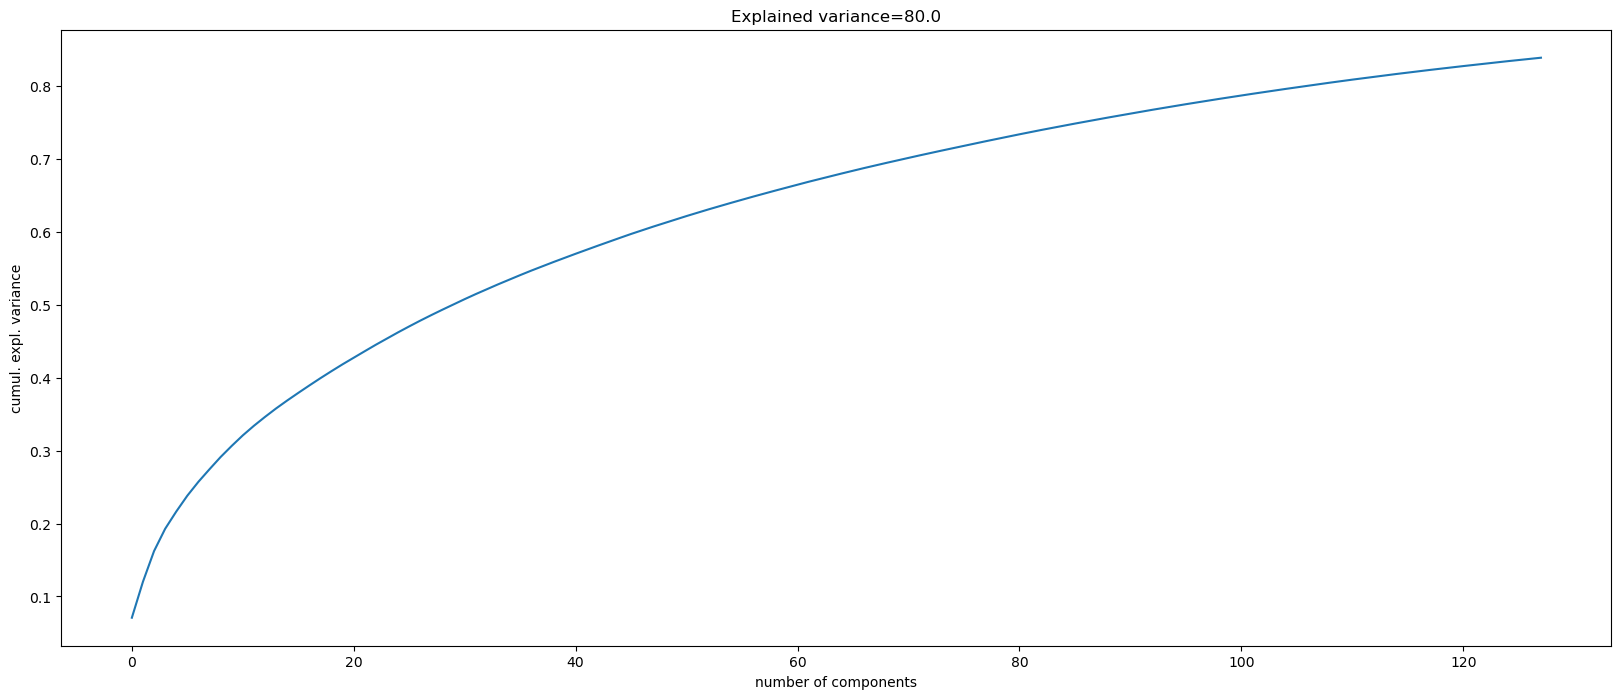

Ratio of the PCA-compressed data memory vs the original data memory: 26.08%


In [19]:
# assess variability 
plt.figure(figsize=(20, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumul. expl. variance')
plt.title(f'Explained variance={np.sum(np.cumsum(pca.explained_variance_ratio_)).round(0)}')
plt.show()

print(f'Ratio of the PCA-compressed data memory vs the original data memory: {(X_train_flat.nbytes / X_train_total.nbytes):.2%}')


***Your answer here.***

As can be seen from the code above, dimensionality reduction from 784 components down to 128 does not significantly affect variance. The ratio is about $26 / 100$. Even though we decreased components number by 6, we still have about 70-80% of variance explained. These results are conclusive and are coherent with the Lassiter (2013) article.

Now, we use SVM with linear kernel to separate the two classes.

In [20]:
%%time
clf = LinearSVC(random_state=42)
clf.fit(X_train_flat, y_train) 

CPU times: user 2.09 s, sys: 15.6 ms, total: 2.11 s
Wall time: 2.11 s


LinearSVC(random_state=42)

Now, let us make the predictions and calculate the accuracy, that is, the ratio of the true predictions to the test sample size.  Use [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) as the quality metric here.

$accuracy(y\_true, y\_pred) = \frac{1}{n}\sum_{i=1}^n [y\_true_i=y\_pred_i],$ where $[a=b]=1$, if $a=b$, and $0$ otherwise.

In [21]:
y_pred = clf.predict(X_test_flat)
acc = np.sum((y_test == y_pred) / y_test.shape[0])
print(f'Test accuracy: {acc}')

Test accuracy: 0.9667338709677415


## Try it from your own input
Try to make your own dataset. You can either make a photo image of an ink-written digit or draw a digit using a graphical editor of your computer or smartphone. Note that the input picture has to be a white number on a black background, like the numbers in the MNIST dataset. It can be either in png or jpeg format. Replace the sample striwith your file name. 

In [22]:
from scipy import misc
from PIL import Image

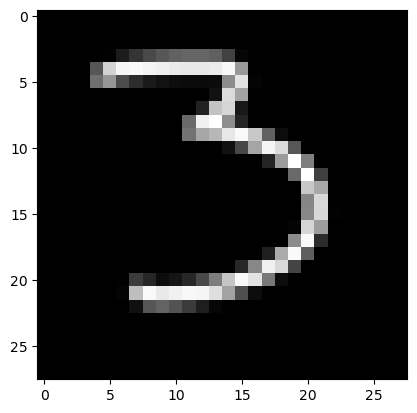

Cool! Digit 3 was recognized as 3


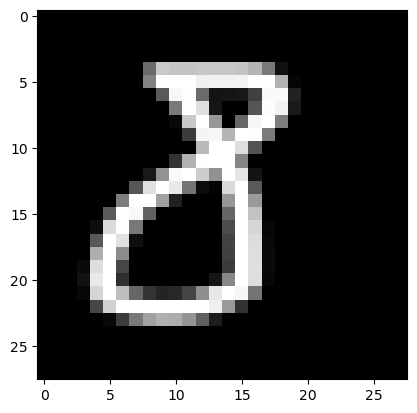

Sorry, the digit 8 was misrecognized as 3 :( 


In [23]:
# iterating over all digits in the folder
for i in (3,8):
    image = Image.open(f'/Users/rustya/Desktop/M.Sc./Linear Algebra/Final project - digit recognition/digits/{i}.png').convert('L')
    new_image = image.resize((28, 28))
    custom = np.array(new_image)
    plt.imshow(custom, cmap='gray')
    plt.show()
    custom = flatten_image(custom).reshape(1,-1)
    custom = scaler.transform(custom)
    custom = pca.transform(custom)

    if i == clf.predict(custom)[0]:
        print(f"Cool! Digit {i} was recognized as {clf.predict(custom)[0]}")

    else:
        print(f"Sorry, the digit {i} was misrecognized as {clf.predict(custom)[0]} :( ")

## Question 3

Repeat the above digit recognition procedure with other 5 to 10 hand-written images. Do your experiments confirm the above accuracy estimate? How do you think, why they confirm (or not confirm) it?

***Your answer here.***  
The model behaves far worse than expected.

I've conducted two different tests:
1. I've completed the model learning over the whole training sample (not just digits $3$ and $8$), and the overall accuracy was rather low - the model on average correctly guessed only $3$ digits out of $10$. Patternwise, it mostly guessed $0$, $1$, and $4$ correctly - other digits were guessed incorrectly.
2. If the learning was conducted over the sample of digits $3$ and $8$ only, out of $10$ tests the model **correctly** guessed the digit $3$ in _all_ cases. For the digit 8, however, the model returned false negative in 80% of cases.

Given the test accuracy of 91-96%, these test results were rather poor. My hunch is that the model is overfitted; it may correctly guess digits provided within the MNIST dataset, but behaves poorly on real world data. I'm cerntaily not the best artist, but the accuracy is still very questionable.

## Task 2
Now let's try another approach explained [here](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) in Section 3. For each digit, we create a new matrix $A$ whose columns are flattened images of this digit. The first several (say, 10) columns of the matrix $U$ from SVD decomposition of $A$ represent a collection of "typical" images of this digit. Given an unrecognized flatten image, among average typical flattened images we find the closets one. Its target value is considered as a prediction for the target of the unrecognized image.

## SVD refesher
As you may recall from the lectures, SVD of a matrix $A$ is a decomposition:
$A = U \Sigma V^T,$ where $U$ and $V$ are orthogonal matrices. In this method we will be utilizing some properties of SVD.

In [25]:
def getSingularVectorsLeft(matrix, number=10):
    u,s,v = svd(matrix)
    return u[:,:number]

In [26]:
def getSingularImage(X_train, y_train, number):
    idxs = [y == number for y in y_train]
    ims = X_train[idxs]

    # init empty matrix
    matrix = np.zeros((len(ims[0]) ** 2, 1))

    # find images whose target is _number_
    for im in ims:
        # flatten image
        im = im.flatten()
        # add to matrix
        matrix = np.append(matrix, im.reshape(-1, 1), axis=1)
    
    return getSingularVectorsLeft(matrix[:, 1:])

Try it first on "0". 

In [30]:
left_basis = getSingularImage(X_train_total, y_train_total, 0)

assert left_basis.shape, (784, 10)

### Task 2.1 (1 point)
Plot first 9 singular images of the digit 0 taking columns of matrix U and reshaping them back into images 28x28. Use `numpy.reshape`.

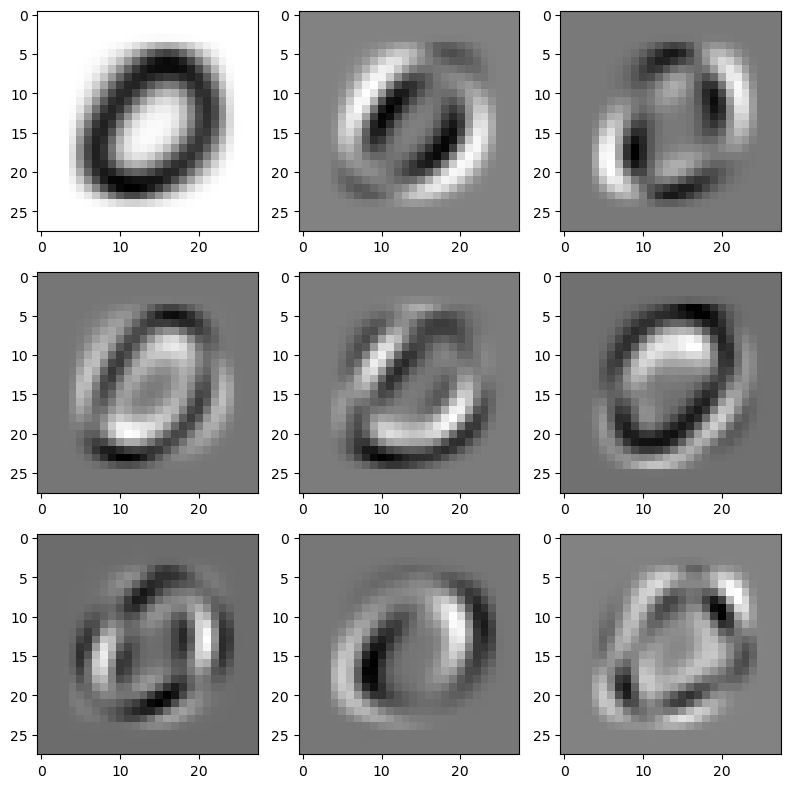

In [31]:
#singular images
plt.figure(figsize=(8,8))

a, b = 3, 3

for i in range(a*b):  
    plt.subplot(b, a, i+1)
    img = left_basis[:,i].reshape(28,28)
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

## Question 4

Reflect on properties of the columns of $U_k$. What properties do you think are contained in each of them? Draw more singular images to help you make conclusions.

***Your answer here.***

One obvious change is the shift from the RGB spectrum to a monochrome. It certainly has some benefits in terms of memory savings for large-scale datasets due to the compression and feature downsizing. For the digit $0$, it is visually hard to tell that something is wrong. However, I provide the example of the digit $5$ below, showing that some images become much harder to recognize, hence potentially worsening the classifition accuracy. Given the lower accuracy on real life examples and considering the implications given by Lassiter (2013) in the attached article, I hardly believe that such composition will produce better results. This doubt is consistent with the fact that on non-MNIST digits were poorly recognized by the model (the example with $8$ above, and with many other digits below). Althouth it may not affect the performance within the MNIST dataset, real-life classification may become worse due to more blur and shift towards the monochrome color scheme. Overall, we see the generall trade-off between data variance and image quality.

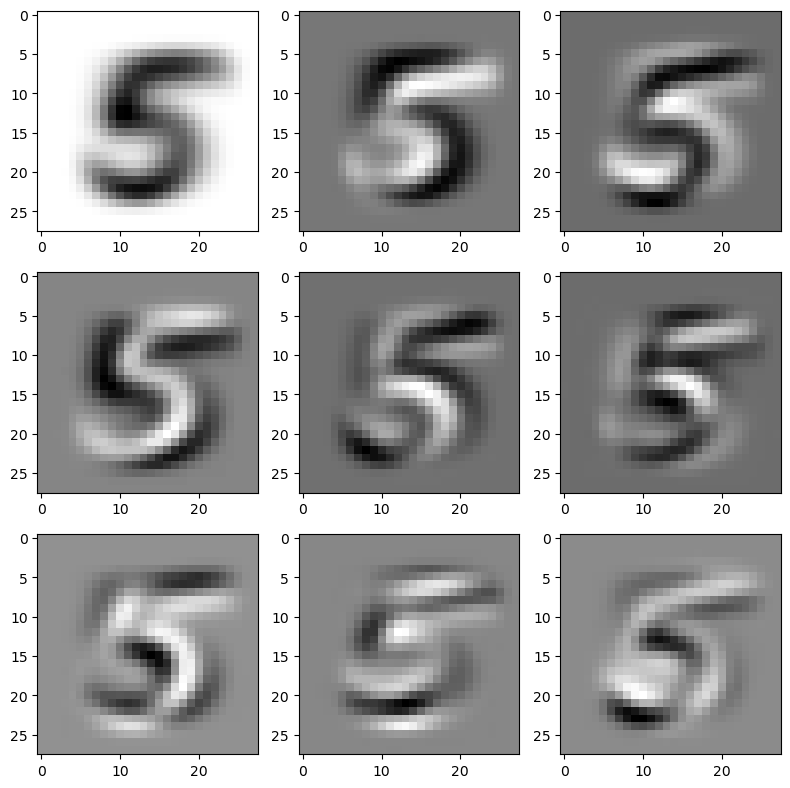

In [40]:
# example of 5

left_basis_5 = getSingularImage(X_train_total, y_train_total, 5)

plt.figure(figsize=(8,8))
a, b = 3,3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    img = left_basis_5[:,i].reshape(28,28)
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

Now let's move on and obtain singular images for all numbers. The matrices $U_k$ from  [the article](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) are represented as `number_basis_matrices[k]`.
This might take a while to finish, feel free to add debug print in your function to know the progress.

In [32]:
# use getSingularImage funciton to get matrices for all numbers
number_basis_matrices = [getSingularImage(X_train_total, y_train_total, digit) for digit in range(10)]

### Task 2.2 (1 point)
Plot the first singular image of each digit, similarly to the previous task.

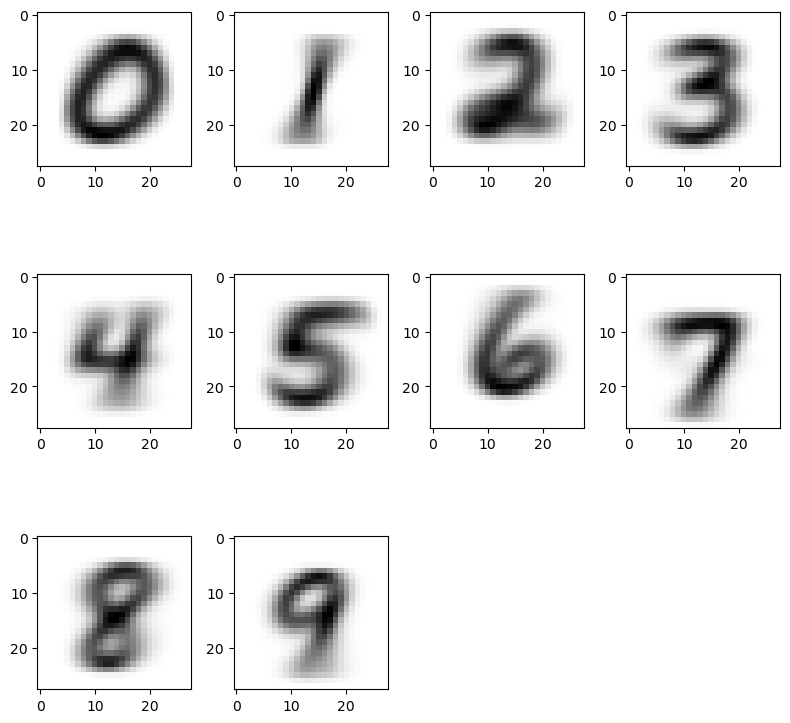

In [33]:
plt.figure(figsize=(8,8))

a, b = 4,3

for i in range(10):  
    plt.subplot(b, a, i+1)
    img = number_basis_matrices[i][:,0].reshape(28,28)
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

In [34]:
dim = number_basis_matrices[0].shape[0]

print(f"Dim size: {dim}")

Dim size: 784


### Task 2.3 (1.5 points)

Here we calculate the new projection matrix for each $U_k$ to apply later in testing:
$pr = (I - U_k \cdot U_{k}^{T})$. Use `numpy.matmul` for matrix multiplication and `numpy.identity` to create an identity matrix. Please note that this operation might also take some time to finish.

In [35]:
# create an array of pr for each number
numeric_values = [np.identity(number_basis_matrices[i].shape[0]) - np.matmul(number_basis_matrices[i], np.transpose(number_basis_matrices[i])) for i in range(10)]

### Task 2.4 (1.5 points)
Implement function utilizing `numeric_values` matrices to predict labels for unknown images. Use `numpy.norm` and enumerate to iterate over numeric values.

In [36]:
def find_closest(test_value, numeric_values):
    stacked_test = test_value.reshape(-1, 1)
    
    # find closest U_k to test_value using norm and return the target digit
    min_distance = np.inf
    target = None
    
    for i, m in enumerate(numeric_values):
        distance = np.linalg.norm(np.matmul(m, stacked_test))
        if distance < min_distance:
            min_distance = distance
            target = i

    return target

# predicting
y_pred = np.array([find_closest(test_value, numeric_values) for test_value in X_test])

# calculating accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")

Accuracy: 93.04%


## Additional task (2 points)
In the first task we trained Linear SVM to separate 3s and 8s. Here you can implement multiclass classification for _all_ numbers in `MNIST`. Use the same function LinearSVC for “one-vs-the-rest” multi-class strategy, see [the documentation](https://scikit-learn.org/stable/modules/svm.html#classification).  Follow the same steps from task 1: scaling, feature selection, training and testing. Is the accuracy of this method greater then the one calculated above?

**Note:** Use `random_state=42` for `PCA` and `LinearSVC`. Training `LinearSVC` on all the data might take a while, that's normal.

In [37]:
# flatten
X_train_tot_flat = np.array([flatten_image(img) for img in X_train_total])
X_test_tot_flat = np.array([flatten_image(img) for img in X_test_total])

# Scandart Scaler
X_train_tot_flat = scaler.fit_transform(X_train_tot_flat)
X_test_tot_flat = scaler.transform(X_test_tot_flat)

# PCA
pca = PCA(n_components=128, random_state=42)
X_train_tot_flat = pca.fit_transform(X_train_tot_flat)
X_test_tot_flat = pca.transform(X_test_tot_flat)

# LinearSVC
clf = LinearSVC(random_state=42)
clf.fit(X_train_tot_flat, y_train_total)

y_pred = clf.predict(X_test_tot_flat)
acc = np.sum((y_test_total == y_pred) / y_test_total.shape[0])

print(f"Accuracy: {acc:.2%}")

Accuracy: 90.79%


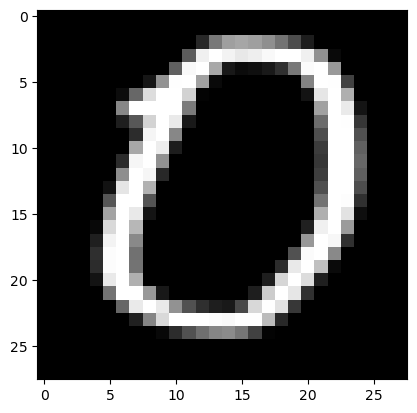

Digit 0 was recognized as 0


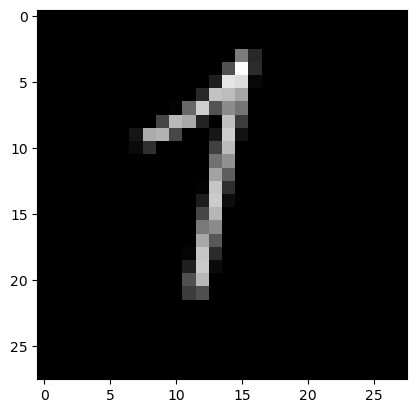

Digit 1 was recognized as 1


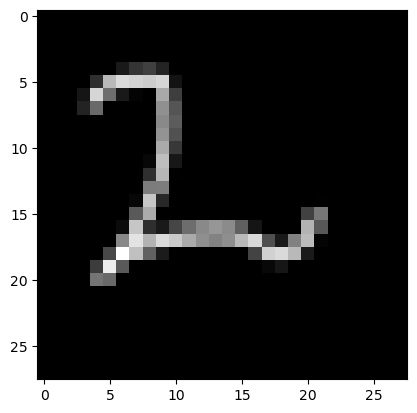

Digit 2 was recognized as 4


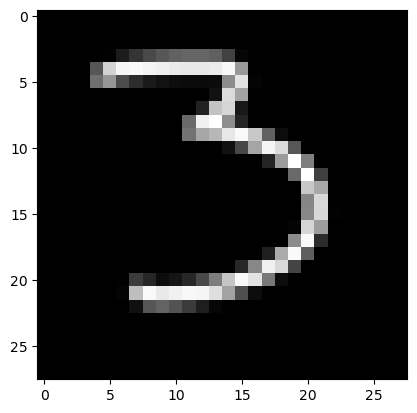

Digit 3 was recognized as 2


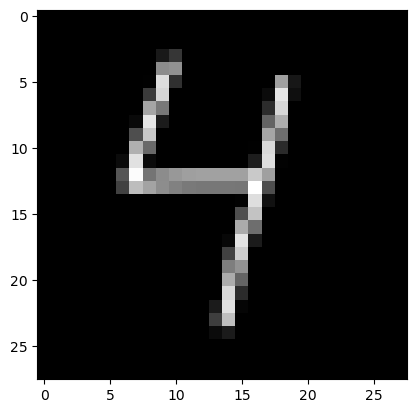

Digit 4 was recognized as 4


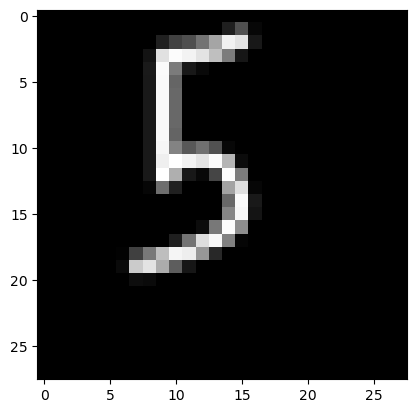

Digit 5 was recognized as 6


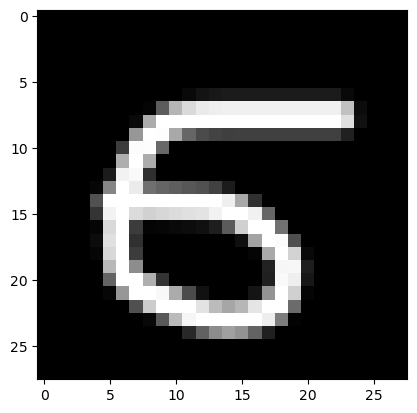

Digit 6 was recognized as 5


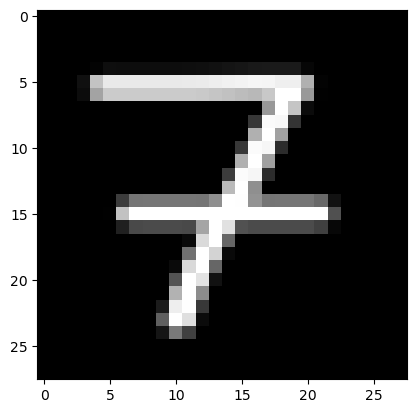

Digit 7 was recognized as 2


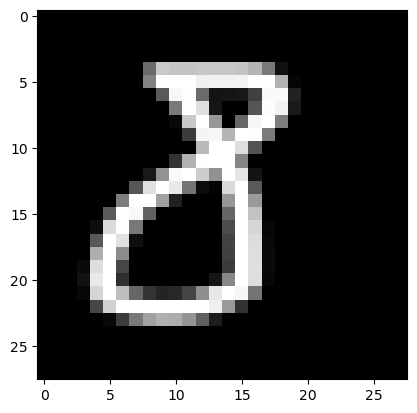

Digit 8 was recognized as 3


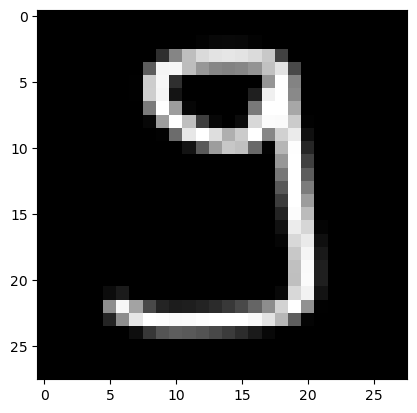

Digit 9 was recognized as 3

	Total successful predictions: 30%


In [38]:
succ_pred = 0

for i in range (10):

    image = Image.open(f'/Users/rustya/Desktop/M.Sc./Linear Algebra/Final project - digit recognition/digits/{i}.png').convert('L')
    new_image = image.resize((28, 28))
    custom = np.array(new_image)
    
    plt.imshow(custom, cmap='gray')
    plt.show()
    
    custom = flatten_image(custom).reshape(1,-1)
    custom = scaler.transform(custom)
    custom = pca.transform(custom)

    value = clf.predict(custom)[0]
    
    print(f"Digit {i} was recognized as {value}")
    
    if value == i:
        succ_pred += 1
print(f"\n\tTotal successful predictions: {succ_pred/10:.0%}")
    